### Lab2 (a) Model preperation

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!ls '/content/drive/MyDrive/2023 - Duke/2025-01/ECE661_ComputerEngineeringMachineLearning&DeepNeuralNets/Assigments/HW4'


FP_layers.py  hw4.ipynb  pretrained_model.pt  __pycache__  resnet20.py	train_util.py


In [55]:
import importlib.util
import sys

# P_layers.py
fp_path = '/content/drive/MyDrive/2023 - Duke/2025-01/ECE661_ComputerEngineeringMachineLearning&DeepNeuralNets/Assigments/HW4/FP_layers.py'
spec = importlib.util.spec_from_file_location("FP_layers", fp_path)
FP_layers = importlib.util.module_from_spec(spec)
sys.modules["FP_layers"] = FP_layers
spec.loader.exec_module(FP_layers)

# Cresnet20.py
resnet_path = '/content/drive/MyDrive/2023 - Duke/2025-01/ECE661_ComputerEngineeringMachineLearning&DeepNeuralNets/Assigments/HW4/resnet20.py'
spec_resnet = importlib.util.spec_from_file_location("resnet20", resnet_path)
resnet20 = importlib.util.module_from_spec(spec_resnet)
sys.modules["resnet20"] = resnet20
spec_resnet.loader.exec_module(resnet20)

#train_util.py
train_util_path = '/content/drive/MyDrive/2023 - Duke/2025-01/ECE661_ComputerEngineeringMachineLearning&DeepNeuralNets/Assigments/HW4/train_util.py'
spec_train = importlib.util.spec_from_file_location("train_util", train_util_path)
train_util = importlib.util.module_from_spec(spec_train)
sys.modules["train_util"] = train_util
spec_train.loader.exec_module(train_util)


In [57]:
from resnet20 import ResNetCIFAR
from train_util import train, finetune, test
import torch
import numpy as np

import time

import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim

from FP_layers import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
net = ResNetCIFAR(num_layers=20, Nbits=None)
net = net.to(device)

In [7]:
device

'cuda'

In [8]:
# Load the best weight parameters
model_path = '/content/drive/MyDrive/2023 - Duke/2025-01/ECE661_ComputerEngineeringMachineLearning&DeepNeuralNets/Assigments/HW4/pretrained_model.pt'
net.load_state_dict(torch.load(model_path))
test(net)

100%|██████████| 170M/170M [00:07<00:00, 23.6MB/s]


Test Loss=0.3231, Test accuracy=0.9151


### Lab2 (b) Prune by percentage

In [9]:
def prune_by_percentage(layer, q=70.0):
    """
    Pruning the weight paramters by threshold.
    :param q: pruning percentile. 'q' percent of the least
    significant weight parameters will be pruned.
    """
    # Convert the weight of "layer" to numpy array
    weight = layer.weight.data.cpu().numpy()

    # Compute the q-th percentile of the abs of the converted array
    threshold = np.percentile(np.abs(weight), q)

    # Generate a binary mask same shape as weight to decide which element to prune
    mask_binary = np.abs(weight) > threshold

    # Convert mask to torch tensor and put on GPU
    mask_tensor = torch.from_numpy(mask_binary).to(layer.weight.device)

    # Multiply the weight by mask to perform pruning
    layer.weight.data = layer.weight.data * mask_tensor

    return threshold


In [36]:
pretrained_model_path = '/content/drive/MyDrive/2023 - Duke/2025-01/ECE661_ComputerEngineeringMachineLearning&DeepNeuralNets/Assigments/HW4/pretrained_model.pt'


## q = 20%

In [37]:
net.load_state_dict(torch.load(pretrained_model_path))
q=20

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # change q value
        prune_by_percentage(layer, q)

        # Optional: Check the sparsity you achieve in each layer
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy()
        # Count number of zeros
        zeros = np.sum(np_weight == 0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))

test(net)

Sparsity of head_conv.0.conv: 0.2013888888888889
Sparsity of body_op.0.conv1.0.conv: 0.20008680555555555
Sparsity of body_op.0.conv2.0.conv: 0.20008680555555555
Sparsity of body_op.1.conv1.0.conv: 0.20008680555555555
Sparsity of body_op.1.conv2.0.conv: 0.20008680555555555
Sparsity of body_op.2.conv1.0.conv: 0.20008680555555555
Sparsity of body_op.2.conv2.0.conv: 0.20008680555555555
Sparsity of body_op.3.conv1.0.conv: 0.20008680555555555
Sparsity of body_op.3.conv2.0.conv: 0.20008680555555555
Sparsity of body_op.4.conv1.0.conv: 0.20008680555555555
Sparsity of body_op.4.conv2.0.conv: 0.20008680555555555
Sparsity of body_op.5.conv1.0.conv: 0.20008680555555555
Sparsity of body_op.5.conv2.0.conv: 0.20008680555555555
Sparsity of body_op.6.conv1.0.conv: 0.20003255208333334
Sparsity of body_op.6.conv2.0.conv: 0.2000054253472222
Sparsity of body_op.7.conv1.0.conv: 0.2000054253472222
Sparsity of body_op.7.conv2.0.conv: 0.2000054253472222
Sparsity of body_op.8.conv1.0.conv: 0.2000054253472222
Spa

## q = 40%

In [12]:
net.load_state_dict(torch.load(pretrained_model_path))
q=40

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # change q value
        prune_by_percentage(layer, q)

        # Optional: Check the sparsity you achieve in each layer
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy()
        # Count number of zeros
        zeros = np.sum(np_weight == 0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))

test(net)

Sparsity of head_conv.0.conv: 0.40046296296296297
Sparsity of body_op.0.conv1.0.conv: 0.4001736111111111
Sparsity of body_op.0.conv2.0.conv: 0.4001736111111111
Sparsity of body_op.1.conv1.0.conv: 0.4001736111111111
Sparsity of body_op.1.conv2.0.conv: 0.4001736111111111
Sparsity of body_op.2.conv1.0.conv: 0.4001736111111111
Sparsity of body_op.2.conv2.0.conv: 0.4001736111111111
Sparsity of body_op.3.conv1.0.conv: 0.3999565972222222
Sparsity of body_op.3.conv2.0.conv: 0.4000651041666667
Sparsity of body_op.4.conv1.0.conv: 0.4000651041666667
Sparsity of body_op.4.conv2.0.conv: 0.4000651041666667
Sparsity of body_op.5.conv1.0.conv: 0.4000651041666667
Sparsity of body_op.5.conv2.0.conv: 0.4000651041666667
Sparsity of body_op.6.conv1.0.conv: 0.4000108506944444
Sparsity of body_op.6.conv2.0.conv: 0.4000108506944444
Sparsity of body_op.7.conv1.0.conv: 0.4000108506944444
Sparsity of body_op.7.conv2.0.conv: 0.4000108506944444
Sparsity of body_op.8.conv1.0.conv: 0.4000108506944444
Sparsity of bod

## q = 60%

In [13]:
net.load_state_dict(torch.load(pretrained_model_path))
q=60

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # change q value
        prune_by_percentage(layer, q)

        # Optional: Check the sparsity you achieve in each layer
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy()
        # Count number of zeros
        zeros = np.sum(np_weight == 0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))

test(net)

Sparsity of head_conv.0.conv: 0.5995370370370371
Sparsity of body_op.0.conv1.0.conv: 0.5998263888888888
Sparsity of body_op.0.conv2.0.conv: 0.5998263888888888
Sparsity of body_op.1.conv1.0.conv: 0.5998263888888888
Sparsity of body_op.1.conv2.0.conv: 0.5998263888888888
Sparsity of body_op.2.conv1.0.conv: 0.5998263888888888
Sparsity of body_op.2.conv2.0.conv: 0.5998263888888888
Sparsity of body_op.3.conv1.0.conv: 0.6000434027777778
Sparsity of body_op.3.conv2.0.conv: 0.6000434027777778
Sparsity of body_op.4.conv1.0.conv: 0.6000434027777778
Sparsity of body_op.4.conv2.0.conv: 0.6000434027777778
Sparsity of body_op.5.conv1.0.conv: 0.6000434027777778
Sparsity of body_op.5.conv2.0.conv: 0.6000434027777778
Sparsity of body_op.6.conv1.0.conv: 0.5999891493055556
Sparsity of body_op.6.conv2.0.conv: 0.5999891493055556
Sparsity of body_op.7.conv1.0.conv: 0.5999891493055556
Sparsity of body_op.7.conv2.0.conv: 0.5999891493055556
Sparsity of body_op.8.conv1.0.conv: 0.5999891493055556
Sparsity of body

## q = 70%

In [14]:
net.load_state_dict(torch.load(pretrained_model_path))
q=70

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # change q value
        prune_by_percentage(layer, q)

        # Optional: Check the sparsity you achieve in each layer
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy()
        # Count number of zeros
        zeros = np.sum(np_weight == 0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))

test(net)

Sparsity of head_conv.0.conv: 0.6990740740740741
Sparsity of body_op.0.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.0.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.1.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.1.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.2.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.2.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.3.conv1.0.conv: 0.6998697916666666
Sparsity of body_op.3.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.4.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.4.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.5.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.5.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.6.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.6.conv2.0.conv: 0.7000054253472222
Sparsity of body_op.7.conv1.0.conv: 0.7000054253472222
Sparsity of body_op.7.conv2.0.conv: 0.7000054253472222
Sparsity of body_op.8.conv1.0.conv: 0.7000054253472222
Sparsity of body

## q = 80%

In [15]:
net.load_state_dict(torch.load(pretrained_model_path))
q=80

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # change q value
        prune_by_percentage(layer, q)

        # Optional: Check the sparsity you achieve in each layer
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy()
        # Count number of zeros
        zeros = np.sum(np_weight == 0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))

test(net)

Sparsity of head_conv.0.conv: 0.7986111111111112
Sparsity of body_op.0.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.0.conv2.0.conv: 0.7999131944444444
Sparsity of body_op.1.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.1.conv2.0.conv: 0.7999131944444444
Sparsity of body_op.2.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.2.conv2.0.conv: 0.7999131944444444
Sparsity of body_op.3.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.3.conv2.0.conv: 0.8000217013888888
Sparsity of body_op.4.conv1.0.conv: 0.8000217013888888
Sparsity of body_op.4.conv2.0.conv: 0.8000217013888888
Sparsity of body_op.5.conv1.0.conv: 0.8000217013888888
Sparsity of body_op.5.conv2.0.conv: 0.8000217013888888
Sparsity of body_op.6.conv1.0.conv: 0.7999674479166666
Sparsity of body_op.6.conv2.0.conv: 0.7999945746527778
Sparsity of body_op.7.conv1.0.conv: 0.7999945746527778
Sparsity of body_op.7.conv2.0.conv: 0.7999945746527778
Sparsity of body_op.8.conv1.0.conv: 0.7999945746527778
Sparsity of body

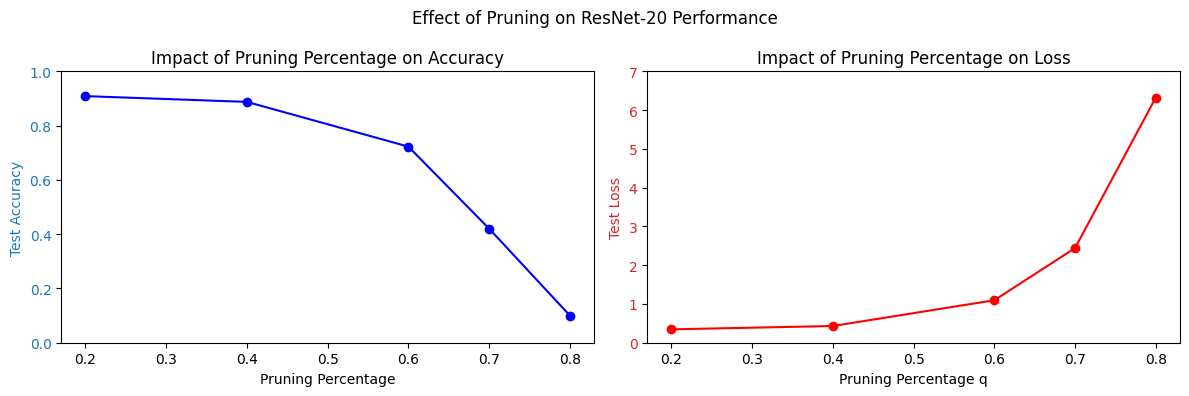

In [16]:
import matplotlib.pyplot as plt

sparsity = [0.2, 0.4, 0.6, 0.7, 0.8]
accuracy = [0.9086, 0.8874, 0.7226, 0.4204, 0.1003]
loss = [0.3449, 0.4311, 1.0955, 2.4417, 6.3235]

y_acc_min, y_acc_max = 0.0, 1.0
y_loss_min, y_loss_max = 0.0, 7.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
ax1.plot(sparsity, accuracy, "bo-", label="Test Accuracy")
ax1.set_xlabel("Pruning Percentage")
ax1.set_ylabel("Test Accuracy", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_title("Impact of Pruning Percentage on Accuracy")
ax1.set_ylim(y_acc_min, y_acc_max)

# Loss
ax2.plot(sparsity, loss, "ro-", label="Test Loss")
ax2.set_xlabel("Pruning Percentage q")
ax2.set_ylabel("Test Loss", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_title("Impact of Pruning Percentage on Loss")
ax2.set_ylim(y_loss_min, y_loss_max)

fig.suptitle("Effect of Pruning on ResNet-20 Performance")
plt.tight_layout()
plt.show()

### Lab2 (c) Finetune pruned model

In [17]:
def finetune_after_prune(net, trainloader, criterion, optimizer, prune=True):
    """
    Finetune the pruned model for a single epoch
    Make sure pruned weights are kept as zero
    """
    # Build a dictionary for the nonzero weights
    weight_mask = {}
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Your code here: generate a mask in GPU torch tensor to have 1 for nonzero element and 0 for zero element
            weight_mask[name] = (layer.weight.data != 0).float()
            weight_mask[name] = (layer.weight.data != 0).float().to(layer.weight.device)
    global_steps = 0
    train_loss = 0
    correct = 0
    total = 0
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if prune:
            for name,layer in net.named_modules():
                if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
                    # Your code here: Use weight_mask to make sure zero elements remains zero
                    layer.weight.data = layer.weight.data * weight_mask[name]

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        global_steps += 1

        if global_steps % 50 == 0:
            end = time.time()
            batch_size = 256
            num_examples_per_second = 50 * batch_size / (end - start)
            print("[Step=%d]\tLoss=%.4f\tacc=%.4f\t%.1f examples/second"
                 % (global_steps, train_loss / (batch_idx + 1), (correct / total), num_examples_per_second))
            start = time.time()



In [18]:
# Get pruned model
#net.load_state_dict(torch.load("pretrained_model.pt"))

net.load_state_dict(torch.load(pretrained_model_path))
for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        prune_by_percentage(layer, q=80.0)

# Training setup, do not change
batch_size=256
lr=0.002
reg=1e-4

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.875, weight_decay=reg, nesterov=False)

==> Preparing data..


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
# Model finetuning
for epoch in range(20):
    print('\nEpoch: %d' % epoch)
    net.train()
    finetune_after_prune(net, trainloader, criterion, optimizer)
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))

    if val_acc > best_acc:
        best_acc = val_acc
        print("Saving...")
        torch.save(net.state_dict(), "net_after_finetune.pt")


Epoch: 0
[Step=50]	Loss=0.9722	acc=0.6848	1678.6 examples/second
[Step=100]	Loss=0.8034	acc=0.7369	2441.0 examples/second
[Step=150]	Loss=0.7185	acc=0.7616	2986.4 examples/second
Test Loss=0.5573, Test acc=0.8183
Saving...

Epoch: 1
[Step=50]	Loss=0.4823	acc=0.8366	1833.9 examples/second
[Step=100]	Loss=0.4579	acc=0.8440	2624.0 examples/second
[Step=150]	Loss=0.4492	acc=0.8471	2538.3 examples/second
Test Loss=0.4860, Test acc=0.8400
Saving...

Epoch: 2
[Step=50]	Loss=0.4150	acc=0.8552	1556.7 examples/second
[Step=100]	Loss=0.4086	acc=0.8583	2747.6 examples/second
[Step=150]	Loss=0.4012	acc=0.8612	2614.2 examples/second
Test Loss=0.4541, Test acc=0.8487
Saving...

Epoch: 3
[Step=50]	Loss=0.3741	acc=0.8733	1833.3 examples/second
[Step=100]	Loss=0.3685	acc=0.8736	2295.7 examples/second
[Step=150]	Loss=0.3668	acc=0.8743	2763.9 examples/second
Test Loss=0.4347, Test acc=0.8571
Saving...

Epoch: 4
[Step=50]	Loss=0.3420	acc=0.8834	1868.5 examples/second
[Step=100]	Loss=0.3405	acc=0.8834	2456

In [20]:
# Check sparsity of the finetuned model, make sure it's not changed
net.load_state_dict(torch.load("net_after_finetune.pt"))


for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here:
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy()
        # Count number of zeros
        zeros = np.sum(np_weight == 0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))

test(net)

Sparsity of head_conv.0.conv: 0.7986111111111112
Sparsity of body_op.0.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.0.conv2.0.conv: 0.7999131944444444
Sparsity of body_op.1.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.1.conv2.0.conv: 0.7999131944444444
Sparsity of body_op.2.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.2.conv2.0.conv: 0.7999131944444444
Sparsity of body_op.3.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.3.conv2.0.conv: 0.8000217013888888
Sparsity of body_op.4.conv1.0.conv: 0.8000217013888888
Sparsity of body_op.4.conv2.0.conv: 0.8000217013888888
Sparsity of body_op.5.conv1.0.conv: 0.8000217013888888
Sparsity of body_op.5.conv2.0.conv: 0.8000217013888888
Sparsity of body_op.6.conv1.0.conv: 0.7999674479166666
Sparsity of body_op.6.conv2.0.conv: 0.7999945746527778
Sparsity of body_op.7.conv1.0.conv: 0.7999945746527778
Sparsity of body_op.7.conv2.0.conv: 0.7999945746527778
Sparsity of body_op.8.conv1.0.conv: 0.7999945746527778
Sparsity of body

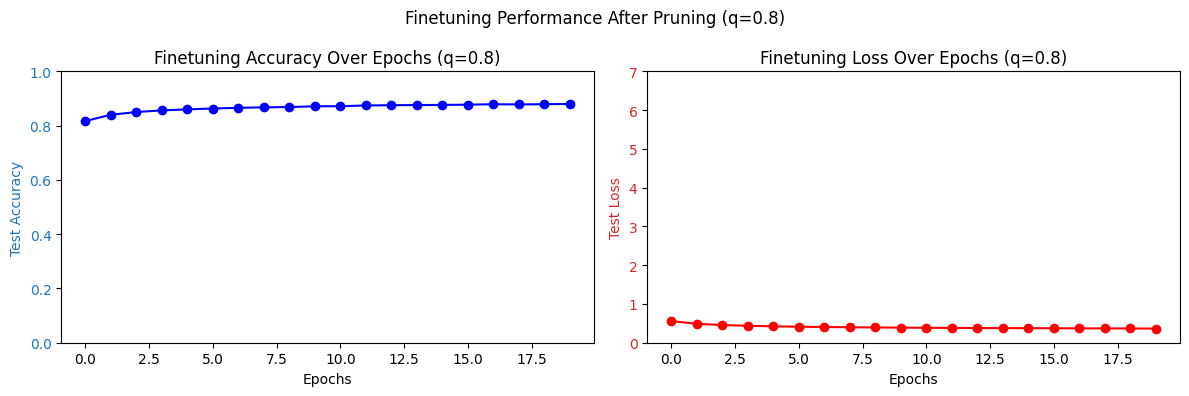

In [21]:
epochs = list(range(20))
test_accuracy = [0.8169, 0.8401, 0.8500, 0.8561, 0.8599, 0.8630, 0.8656,
                0.8672, 0.8685, 0.8711, 0.8714, 0.8743, 0.8752, 0.8757,
                0.8762, 0.8772, 0.8788, 0.8780, 0.8789, 0.8798]
test_loss = [0.5583, 0.4881, 0.4562, 0.4364, 0.4227, 0.4125, 0.4061,
             0.3988, 0.3934, 0.3894, 0.3850, 0.3818, 0.3789, 0.3768,
             0.3748, 0.3736, 0.3704, 0.3690, 0.3685, 0.3641]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy over epochs
ax1.plot(epochs, test_accuracy, 'bo-', label='Test Accuracy')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Test Accuracy", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title("Finetuning Accuracy Over Epochs (q=0.8)")
ax1.set_ylim(y_acc_min, y_acc_max)

# Loss over epochs
ax2.plot(epochs, test_loss, 'ro-', label='Test Loss')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Test Loss", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title("Finetuning Loss Over Epochs (q=0.8)")
ax2.set_ylim(y_loss_min, y_loss_max)

fig.suptitle("Finetuning Performance After Pruning (q=0.8)")
plt.tight_layout()
plt.show()



### Lab2 (d) Iterative pruning

In [22]:
#net.load_state_dict(torch.load("pretrained_model.pt"))
net.load_state_dict(torch.load(pretrained_model_path))
best_acc = 0.
for epoch in range(20):
    print('\nEpoch: %d' % epoch)

    net.train()
    if epoch<10:
        for name,layer in net.named_modules():
            if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
                # Increase model sparsity
                q = 8 * (epoch + 1)
                prune_by_percentage(layer, q=q)
    if epoch<9:
        finetune_after_prune(net, trainloader, criterion, optimizer,prune=False)
    else:
        finetune_after_prune(net, trainloader, criterion, optimizer)

    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))

    if epoch>=10:
        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "net_after_iterative_prune.pt")


Epoch: 0
[Step=50]	Loss=0.0477	acc=0.9845	1406.9 examples/second
[Step=100]	Loss=0.0493	acc=0.9843	2828.6 examples/second
[Step=150]	Loss=0.0484	acc=0.9846	2878.6 examples/second
Test Loss=0.3222, Test acc=0.9156

Epoch: 1
[Step=50]	Loss=0.0500	acc=0.9838	1879.5 examples/second
[Step=100]	Loss=0.0483	acc=0.9839	2192.9 examples/second
[Step=150]	Loss=0.0498	acc=0.9836	2789.1 examples/second
Test Loss=0.3264, Test acc=0.9134

Epoch: 2
[Step=50]	Loss=0.0514	acc=0.9826	1655.0 examples/second
[Step=100]	Loss=0.0515	acc=0.9825	2970.5 examples/second
[Step=150]	Loss=0.0524	acc=0.9820	2232.2 examples/second
Test Loss=0.3278, Test acc=0.9124

Epoch: 3
[Step=50]	Loss=0.0587	acc=0.9802	1558.2 examples/second
[Step=100]	Loss=0.0581	acc=0.9808	2918.4 examples/second
[Step=150]	Loss=0.0582	acc=0.9804	2958.4 examples/second
Test Loss=0.3338, Test acc=0.9113

Epoch: 4
[Step=50]	Loss=0.0724	acc=0.9773	1817.1 examples/second
[Step=100]	Loss=0.0704	acc=0.9767	2216.3 examples/second
[Step=150]	Loss=0.068

In [23]:
# Check sparsity of the final model, make sure it's 80%
net.load_state_dict(torch.load("net_after_iterative_prune.pt"))

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here: can copy from previous question
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy()
        # Count number of zeros
        zeros = np.sum(np_weight == 0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))

test(net)

Sparsity of head_conv.0.conv: 0.7986111111111112
Sparsity of body_op.0.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.0.conv2.0.conv: 0.7999131944444444
Sparsity of body_op.1.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.1.conv2.0.conv: 0.7999131944444444
Sparsity of body_op.2.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.2.conv2.0.conv: 0.7999131944444444
Sparsity of body_op.3.conv1.0.conv: 0.7999131944444444
Sparsity of body_op.3.conv2.0.conv: 0.8000217013888888
Sparsity of body_op.4.conv1.0.conv: 0.8000217013888888
Sparsity of body_op.4.conv2.0.conv: 0.8000217013888888
Sparsity of body_op.5.conv1.0.conv: 0.8000217013888888
Sparsity of body_op.5.conv2.0.conv: 0.8000217013888888
Sparsity of body_op.6.conv1.0.conv: 0.7999674479166666
Sparsity of body_op.6.conv2.0.conv: 0.7999945746527778
Sparsity of body_op.7.conv1.0.conv: 0.7999945746527778
Sparsity of body_op.7.conv2.0.conv: 0.7999945746527778
Sparsity of body_op.8.conv1.0.conv: 0.7999945746527778
Sparsity of body

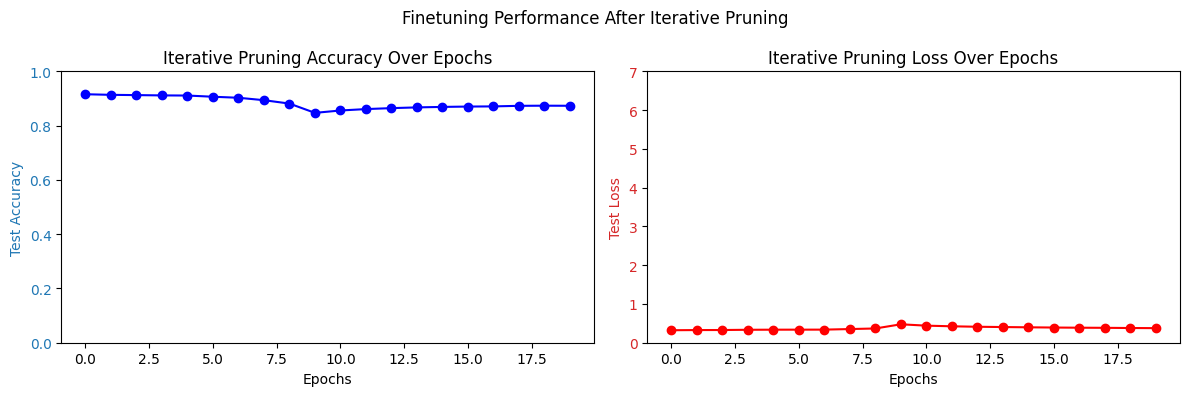

In [39]:
epochs = list(range(20))
test_accuracy = [0.9156, 0.9134, 0.9124, 0.9113, 0.9108, 0.9064, 0.9026, 0.8937, 0.8812, 0.8470, 0.8557, 0.8609, 0.8644, 0.8671, 0.8689, 0.8702, 0.8708, 0.8729, 0.8734, 0.8731]
test_loss = [0.3222, 0.3264, 0.3278, 0.3338, 0.3362, 0.3370, 0.3379, 0.3526, 0.3675, 0.4753, 0.4401, 0.4237, 0.4118, 0.4043, 0.3975, 0.3918, 0.3873, 0.3843, 0.3793, 0.3761]

y_acc_min, y_acc_max = 0.0, 1.0
y_loss_min, y_loss_max = 0.0, 7.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
ax1.plot(epochs, test_accuracy, 'bo-', label='Test Accuracy')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Test Accuracy", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title("Iterative Pruning Accuracy Over Epochs")
ax1.set_ylim(y_acc_min, y_acc_max)

# Loss
ax2.plot(epochs, test_loss, 'ro-', label='Test Loss')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Test Loss", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title("Iterative Pruning Loss Over Epochs")
ax2.set_ylim(y_loss_min, y_loss_max)

fig.suptitle("Finetuning Performance After Iterative Pruning")
plt.tight_layout()
plt.show()


### Lab2 (e) Global iterative pruning

In [30]:
def global_prune_by_percentage(net, q=70.0):
    """
    Pruning the weight paramters by threshold.
    :param q: pruning percentile. 'q' percent of the least
    significant weight parameters will be pruned.
    """
    # A list to gather all the weights
    flattened_weights = []
    # Find global pruning threshold
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Convert weight to numpy
            np_weight = layer.weight.data.cpu().numpy()

            # Flatten the weight and append to flattened_weights
            flattened_weights.append(np.abs(np_weight.flatten()))

    # Concate all weights into a np array
    flattened_weights = np.concatenate(flattened_weights)
    # Find global pruning threshold
    thres = np.percentile(flattened_weights, q)

    # Apply pruning threshold to all layers
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Convert weight to numpy
            weight = layer.weight.data.cpu().numpy()

            # Generate a binary mask same shape as weight to decide which element to
            mask_binary = np.abs(weight) > thres

            # Convert mask to torch tensor and put on GPU
            mask_tensor = torch.from_numpy(mask_binary).to(layer.weight.device)

            # Multiply the weight by mask to perform pruning
            layer.weight.data = layer.weight.data * mask_tensor


In [31]:
#net.load_state_dict(torch.load("pretrained_model.pt"))
net.load_state_dict(torch.load(pretrained_model_path))
best_acc = 0.
for epoch in range(20):
    print('\nEpoch: %d' % epoch)

    net.train()
    if epoch<10:
        # Increase model sparsity
        q = 8 * (epoch + 1)
        global_prune_by_percentage(net, q=q)
    if epoch<9:
        finetune_after_prune(net, trainloader, criterion, optimizer,prune=False)
    else:
        finetune_after_prune(net, trainloader, criterion, optimizer)

    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))

    if epoch>=10:
        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "net_after_global_iterative_prune.pt")


Epoch: 0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Step=50]	Loss=0.0484	acc=0.9841	1858.6 examples/second
[Step=100]	Loss=0.0485	acc=0.9844	2404.4 examples/second
[Step=150]	Loss=0.0483	acc=0.9845	2442.8 examples/second
Test Loss=0.3243, Test acc=0.9142

Epoch: 1
[Step=50]	Loss=0.0483	acc=0.9841	1495.2 examples/second
[Step=100]	Loss=0.0483	acc=0.9846	2905.1 examples/second
[Step=150]	Loss=0.0490	acc=0.9844	2313.4 examples/second
Test Loss=0.3268, Test acc=0.9142

Epoch: 2
[Step=50]	Loss=0.0496	acc=0.9850	1601.6 examples/second
[Step=100]	Loss=0.0497	acc=0.9840	2700.9 examples/second
[Step=150]	Loss=0.0491	acc=0.9838	2872.0 examples/second
Test Loss=0.3241, Test acc=0.9157

Epoch: 3
[Step=50]	Loss=0.0535	acc=0.9820	1758.4 examples/second
[Step=100]	Loss=0.0539	acc=0.9825	2231.0 examples/second
[Step=150]	Loss=0.0546	acc=0.9822	2897.0 examples/second
Test Loss=0.3262, Test acc=0.9144

Epoch: 4
[Step=50]	Loss=0.0614	acc=0.9793	1643.5 examples/second
[Step=100]	Loss=0.0589	acc=0.9802	2664.8 examples/second
[Step=150]	Loss=0.0582	acc=0.98

In [32]:
net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))

zeros_sum = 0
total_sum = 0
for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here:
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy()
        # Count number of zeros
        zeros = np.sum(np_weight == 0)
        # Count number of parameters
        total = np_weight.size
        zeros_sum+=zeros
        total_sum+=total
        print('Sparsity of '+name+': '+str(zeros/total))
print('Total sparsity of: '+str(zeros_sum/total_sum))
test(net)

Sparsity of head_conv.0.conv: 0.3101851851851852
Sparsity of body_op.0.conv1.0.conv: 0.6575520833333334
Sparsity of body_op.0.conv2.0.conv: 0.6397569444444444
Sparsity of body_op.1.conv1.0.conv: 0.6263020833333334
Sparsity of body_op.1.conv2.0.conv: 0.6488715277777778
Sparsity of body_op.2.conv1.0.conv: 0.6315104166666666
Sparsity of body_op.2.conv2.0.conv: 0.6701388888888888
Sparsity of body_op.3.conv1.0.conv: 0.6234809027777778
Sparsity of body_op.3.conv2.0.conv: 0.6879340277777778
Sparsity of body_op.4.conv1.0.conv: 0.7261284722222222
Sparsity of body_op.4.conv2.0.conv: 0.7822265625
Sparsity of body_op.5.conv1.0.conv: 0.7247178819444444
Sparsity of body_op.5.conv2.0.conv: 0.8133680555555556
Sparsity of body_op.6.conv1.0.conv: 0.7324761284722222
Sparsity of body_op.6.conv2.0.conv: 0.7647569444444444
Sparsity of body_op.7.conv1.0.conv: 0.7769368489583334
Sparsity of body_op.7.conv2.0.conv: 0.8260633680555556
Sparsity of body_op.8.conv1.0.conv: 0.8525119357638888
Sparsity of body_op.8.

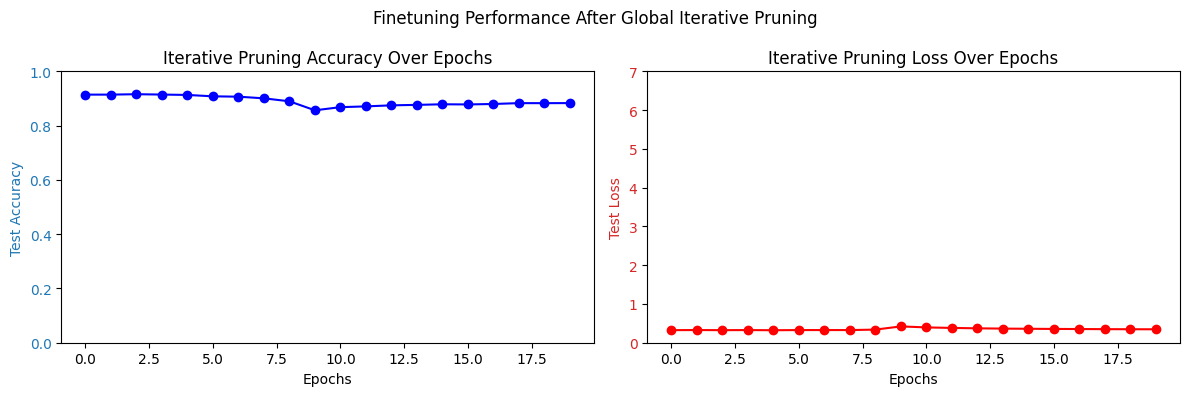

In [40]:

epochs = list(range(20))
test_accuracy = [0.9142, 0.9142, 0.9157, 0.9144, 0.9130, 0.9079, 0.9066, 0.9005, 0.8896, 0.8564,
                 0.8680, 0.8708, 0.8747, 0.8764, 0.8786, 0.8780, 0.8797, 0.8828, 0.8827, 0.8830]
test_loss = [0.3243, 0.3268, 0.3241, 0.3262, 0.3222, 0.3262, 0.3266, 0.3261, 0.3385, 0.4207,
             0.3950, 0.3819, 0.3712, 0.3642, 0.3595, 0.3557, 0.3530, 0.3499, 0.3477, 0.3465]


y_acc_min, y_acc_max = 0.0, 1.0
y_loss_min, y_loss_max = 0.0, 7.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
ax1.plot(epochs, test_accuracy, 'bo-', label='Test Accuracy')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Test Accuracy", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title("Iterative Pruning Accuracy Over Epochs")
ax1.set_ylim(y_acc_min, y_acc_max)

# Loss
ax2.plot(epochs, test_loss, 'ro-', label='Test Loss')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Test Loss", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title("Iterative Pruning Loss Over Epochs")
ax2.set_ylim(y_loss_min, y_loss_max)

fig.suptitle("Finetuning Performance After Global Iterative Pruning")
plt.tight_layout()
plt.show()


### Lab 3 (b) and (c): Fixed-point quantization

## Nbits = 6

In [60]:
# Define quantized model and load weight
Nbits = 6 #Change this value to finish (b) and (c)

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)

net.load_state_dict(torch.load(pretrained_model_path))
test(net)

Test Loss=0.3364, Test accuracy=0.9145


In [61]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..

Epoch: 0
[Step=50]	Loss=0.0499	acc=0.9838	1301.4 examples/second
[Step=100]	Loss=0.0492	acc=0.9839	2305.3 examples/second
[Step=150]	Loss=0.0485	acc=0.9841	1956.1 examples/second
Test Loss=0.3245, Test acc=0.9154
Saving...

Epoch: 1
[Step=200]	Loss=0.0640	acc=0.9775	1253.4 examples/second
[Step=250]	Loss=0.0490	acc=0.9837	2135.3 examples/second
[Step=300]	Loss=0.0498	acc=0.9833	2702.3 examples/second
[Step=350]	Loss=0.0497	acc=0.9836	1995.1 examples/second
Test Loss=0.3243, Test acc=0.9151

Epoch: 2
[Step=400]	Loss=0.0396	acc=0.9863	1116.7 examples/second
[Step=450]	Loss=0.0461	acc=0.9853	1928.1 examples/second
[Step=500]	Loss=0.0488	acc=0.9842	2499.7 examples/second
[Step=550]	Loss=0.0485	acc=0.9846	2074.9 examples/second
Test Loss=0.3249, Test acc=0.9157
Saving...

Epoch: 3
[Step=600]	Loss=0.0481	acc=0.9857	1117.5 examples/second
[Step=650]	Loss=0.0488	acc=0.9855	2273.5 examples/second
[Step=700]	Loss=0.0470	acc=0.9861	2007.7 examples/second
[Step=750]	Loss=0.04

# Nbits = 5

In [62]:
# Define quantized model and load weight
Nbits = 5 #Change this value to finish (b) and (c)

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)

net.load_state_dict(torch.load(pretrained_model_path))
test(net)


Test Loss=0.3390, Test accuracy=0.9112


In [63]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..

Epoch: 0
[Step=50]	Loss=0.0535	acc=0.9826	1421.5 examples/second
[Step=100]	Loss=0.0517	acc=0.9832	2682.8 examples/second
[Step=150]	Loss=0.0525	acc=0.9828	2057.2 examples/second
Test Loss=0.3308, Test acc=0.9138
Saving...

Epoch: 1
[Step=200]	Loss=0.0482	acc=0.9854	1368.3 examples/second
[Step=250]	Loss=0.0517	acc=0.9821	1900.5 examples/second
[Step=300]	Loss=0.0515	acc=0.9826	2672.0 examples/second
[Step=350]	Loss=0.0511	acc=0.9832	2278.4 examples/second
Test Loss=0.3303, Test acc=0.9134

Epoch: 2
[Step=400]	Loss=0.0496	acc=0.9839	1292.1 examples/second
[Step=450]	Loss=0.0509	acc=0.9838	2022.0 examples/second
[Step=500]	Loss=0.0506	acc=0.9844	2600.8 examples/second
[Step=550]	Loss=0.0505	acc=0.9844	2686.5 examples/second
Test Loss=0.3275, Test acc=0.9145
Saving...

Epoch: 3
[Step=600]	Loss=0.0532	acc=0.9814	1256.1 examples/second
[Step=650]	Loss=0.0539	acc=0.9819	2332.1 examples/second
[Step=700]	Loss=0.0521	acc=0.9833	2126.8 examples/second
[Step=750]	Loss=0.05

## Nbits = 4

In [58]:
# Define quantized model and load weight
Nbits = 4 #Change this value to finish (b) and (c)

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)

net.load_state_dict(torch.load(pretrained_model_path))
test(net)


Test Loss=0.3861, Test accuracy=0.8972


In [59]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch: 0
[Step=50]	Loss=0.0656	acc=0.9779	1562.9 examples/second
[Step=100]	Loss=0.0651	acc=0.9782	2482.4 examples/second
[Step=150]	Loss=0.0646	acc=0.9778	2089.5 examples/second
Test Loss=0.3356, Test acc=0.9098
Saving...

Epoch: 1
[Step=200]	Loss=0.0555	acc=0.9785	1343.9 examples/second
[Step=250]	Loss=0.0615	acc=0.9789	2013.7 examples/second
[Step=300]	Loss=0.0593	acc=0.9796	2707.9 examples/second
[Step=350]	Loss=0.0616	acc=0.9787	2020.6 examples/second
Test Loss=0.3358, Test acc=0.9073

Epoch: 2
[Step=400]	Loss=0.0550	acc=0.9810	1357.2 examples/second
[Step=450]	Loss=0.0602	acc=0.9796	1994.8 examples/second
[Step=500]	Loss=0.0605	acc=0.9799	2657.6 examples/second
[Step=550]	Loss=0.0599	acc=0.9801	2466.4 examples/second
Test Loss=0.3357, Test acc=0.9096

Epoch: 3
[Step=600]	Loss=0.0571	acc=0.9821	1290.4 examples/second
[Step=650]	Loss=0.0595	acc=0.9808	2278.9 examples/second
[Step=700]	Loss=0.0601	acc=0.9800	2435.6 examples/second
[Step=750]	Loss=0.0600	acc=0.9800	2743.0 examples/s

## Nbits = 3

In [64]:
# Define quantized model and load weight
Nbits = 3

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)

net.load_state_dict(torch.load(pretrained_model_path))
test(net)


Test Loss=0.9874, Test accuracy=0.7662


In [65]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..

Epoch: 0
[Step=50]	Loss=0.1728	acc=0.9383	1581.1 examples/second
[Step=100]	Loss=0.1623	acc=0.9421	1832.3 examples/second
[Step=150]	Loss=0.1541	acc=0.9446	2525.8 examples/second
Test Loss=0.3955, Test acc=0.8946
Saving...

Epoch: 1
[Step=200]	Loss=0.1250	acc=0.9541	1146.8 examples/second
[Step=250]	Loss=0.1256	acc=0.9542	2361.0 examples/second
[Step=300]	Loss=0.1233	acc=0.9545	2031.6 examples/second
[Step=350]	Loss=0.1216	acc=0.9551	2355.6 examples/second
Test Loss=0.3816, Test acc=0.9001
Saving...

Epoch: 2
[Step=400]	Loss=0.1085	acc=0.9609	1113.8 examples/second
[Step=450]	Loss=0.1151	acc=0.9585	2482.7 examples/second
[Step=500]	Loss=0.1142	acc=0.9594	1952.6 examples/second
[Step=550]	Loss=0.1136	acc=0.9593	2364.9 examples/second
Test Loss=0.3813, Test acc=0.9001

Epoch: 3
[Step=600]	Loss=0.1161	acc=0.9580	1142.3 examples/second
[Step=650]	Loss=0.1101	acc=0.9611	2606.5 examples/second
[Step=700]	Loss=0.1073	acc=0.9622	1955.6 examples/second
[Step=750]	Loss=0.10

## Nbits = 2

In [66]:
# Define quantized model and load weight
Nbits = 2

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)

net.load_state_dict(torch.load(pretrained_model_path))
test(net)


Test Loss=9.5441, Test accuracy=0.0899


In [67]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..

Epoch: 0
[Step=50]	Loss=1.3580	acc=0.6211	1356.7 examples/second
[Step=100]	Loss=1.0694	acc=0.6829	2659.1 examples/second
[Step=150]	Loss=0.9420	acc=0.7128	2355.6 examples/second
Test Loss=0.7303, Test acc=0.7759
Saving...

Epoch: 1
[Step=200]	Loss=0.5893	acc=0.7969	1269.6 examples/second
[Step=250]	Loss=0.5756	acc=0.8056	1892.8 examples/second
[Step=300]	Loss=0.5591	acc=0.8118	2671.2 examples/second
[Step=350]	Loss=0.5444	acc=0.8165	2645.5 examples/second
Test Loss=0.6395, Test acc=0.8068
Saving...

Epoch: 2
[Step=400]	Loss=0.4990	acc=0.8296	1213.3 examples/second
[Step=450]	Loss=0.4824	acc=0.8337	2089.2 examples/second
[Step=500]	Loss=0.4738	acc=0.8374	2457.3 examples/second
[Step=550]	Loss=0.4647	acc=0.8411	2648.6 examples/second
Test Loss=0.6084, Test acc=0.8099
Saving...

Epoch: 3
[Step=600]	Loss=0.4357	acc=0.8516	1222.8 examples/second
[Step=650]	Loss=0.4237	acc=0.8553	2229.1 examples/second
[Step=700]	Loss=0.4210	acc=0.8557	2242.7 examples/second
[Step=750]

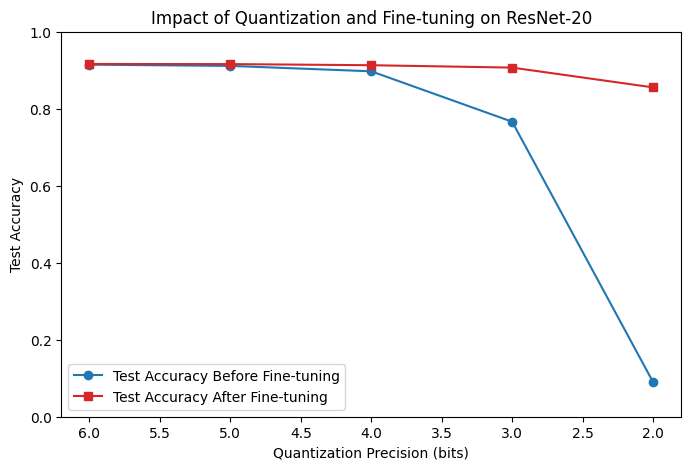

In [71]:
bits = [6, 5, 4, 3, 2]
accuracy_before = [0.9145, 0.9112, 0.8972, 0.7662, 0.0899]
accuracy_after = [0.9162, 0.9159, 0.9130, 0.9068, 0.8554]

y_acc_min, y_acc_max = 0.0, 1.0

plt.figure(figsize=(8, 5))
plt.plot(bits, accuracy_before, marker='o', linestyle='-', label='Test Accuracy Before Fine-tuning', color='tab:blue')
plt.plot(bits, accuracy_after, marker='s', linestyle='-', label='Test Accuracy After Fine-tuning', color='tab:red')

plt.xlabel('Quantization Precision (bits)')
plt.ylabel('Test Accuracy')
plt.title('Impact of Quantization and Fine-tuning on ResNet-20')
plt.ylim(y_acc_min, y_acc_max)
plt.gca().invert_xaxis()
plt.legend()
plt.show()


### Lab3 (d) Quantize pruned model

My best model was Global Iterative Pruning . lab 2 E

## Nbits = 6

In [73]:
# Define quantized model and load weight
Nbits = 6

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)
net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
test(net)


Test Loss=0.3480, Test accuracy=0.8820


In [74]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..

Epoch: 0
[Step=50]	Loss=0.2440	acc=0.9152	1256.6 examples/second
[Step=100]	Loss=0.2297	acc=0.9198	1651.0 examples/second
[Step=150]	Loss=0.2223	acc=0.9222	2003.8 examples/second
Test Loss=0.3744, Test acc=0.8847
Saving...

Epoch: 1
[Step=200]	Loss=0.2097	acc=0.9316	1076.0 examples/second
[Step=250]	Loss=0.1960	acc=0.9321	1496.4 examples/second
[Step=300]	Loss=0.1916	acc=0.9331	2187.2 examples/second
[Step=350]	Loss=0.1951	acc=0.9319	2418.3 examples/second
Test Loss=0.3473, Test acc=0.8893
Saving...

Epoch: 2
[Step=400]	Loss=0.1894	acc=0.9263	1127.4 examples/second
[Step=450]	Loss=0.1876	acc=0.9334	1642.5 examples/second
[Step=500]	Loss=0.1850	acc=0.9342	2492.9 examples/second
[Step=550]	Loss=0.1858	acc=0.9348	1773.2 examples/second
Test Loss=0.3491, Test acc=0.8902
Saving...

Epoch: 3
[Step=600]	Loss=0.1787	acc=0.9368	1193.9 examples/second
[Step=650]	Loss=0.1806	acc=0.9369	2052.8 examples/second
[Step=700]	Loss=0.1801	acc=0.9365	2493.5 examples/second
[Step=750]

## Nbits = 5

In [75]:
# Define quantized model and load weight
Nbits = 5

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)
net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
test(net)


Test Loss=0.3672, Test accuracy=0.8753


In [76]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..

Epoch: 0
[Step=50]	Loss=0.3448	acc=0.8866	1665.6 examples/second
[Step=100]	Loss=0.3027	acc=0.8981	2071.4 examples/second
[Step=150]	Loss=0.2835	acc=0.9030	2510.4 examples/second
Test Loss=0.3702, Test acc=0.8790
Saving...

Epoch: 1
[Step=200]	Loss=0.2736	acc=0.9014	1187.8 examples/second
[Step=250]	Loss=0.2331	acc=0.9171	2334.8 examples/second
[Step=300]	Loss=0.2277	acc=0.9182	2075.9 examples/second
[Step=350]	Loss=0.2241	acc=0.9197	2603.0 examples/second
Test Loss=0.3631, Test acc=0.8836
Saving...

Epoch: 2
[Step=400]	Loss=0.1962	acc=0.9272	1081.3 examples/second
[Step=450]	Loss=0.2003	acc=0.9275	2621.6 examples/second
[Step=500]	Loss=0.1994	acc=0.9281	2194.1 examples/second
[Step=550]	Loss=0.2004	acc=0.9283	2448.7 examples/second
Test Loss=0.3620, Test acc=0.8863
Saving...

Epoch: 3
[Step=600]	Loss=0.2000	acc=0.9297	1121.2 examples/second
[Step=650]	Loss=0.1943	acc=0.9313	2535.3 examples/second
[Step=700]	Loss=0.1919	acc=0.9316	2296.3 examples/second
[Step=750]

## Nbits = 4

In [77]:
# Define quantized model and load weight
Nbits = 4

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)
net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
test(net)


Test Loss=0.4027, Test accuracy=0.8604


In [78]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..

Epoch: 0
[Step=50]	Loss=0.9611	acc=0.7278	1612.0 examples/second
[Step=100]	Loss=0.8112	acc=0.7712	2082.4 examples/second
[Step=150]	Loss=0.7129	acc=0.7924	2509.0 examples/second
Test Loss=0.5223, Test acc=0.8255
Saving...

Epoch: 1
[Step=200]	Loss=0.4138	acc=0.8721	1121.6 examples/second
[Step=250]	Loss=0.3977	acc=0.8703	2454.9 examples/second
[Step=300]	Loss=0.3918	acc=0.8714	2006.9 examples/second
[Step=350]	Loss=0.3863	acc=0.8729	2636.5 examples/second
Test Loss=0.4318, Test acc=0.8539
Saving...

Epoch: 2
[Step=400]	Loss=0.3321	acc=0.8896	1159.5 examples/second
[Step=450]	Loss=0.3315	acc=0.8882	2402.2 examples/second
[Step=500]	Loss=0.3236	acc=0.8904	2120.7 examples/second
[Step=550]	Loss=0.3206	acc=0.8918	2488.3 examples/second
Test Loss=0.4151, Test acc=0.8646
Saving...

Epoch: 3
[Step=600]	Loss=0.2861	acc=0.8994	1148.2 examples/second
[Step=650]	Loss=0.2881	acc=0.9001	2613.6 examples/second
[Step=700]	Loss=0.2848	acc=0.9012	2134.5 examples/second
[Step=750]

## Nbits = 3

In [79]:
# Define quantized model and load weight
Nbits = 3

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)
net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
test(net)


Test Loss=0.9069, Test accuracy=0.7118


In [80]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..

Epoch: 0
[Step=50]	Loss=2.0731	acc=0.3934	1514.3 examples/second
[Step=100]	Loss=1.6879	acc=0.4651	2065.3 examples/second
[Step=150]	Loss=1.4863	acc=0.5154	2518.0 examples/second
Test Loss=0.8924, Test acc=0.6849
Saving...

Epoch: 1
[Step=200]	Loss=0.8912	acc=0.6797	1172.7 examples/second
[Step=250]	Loss=0.8514	acc=0.7002	2261.7 examples/second
[Step=300]	Loss=0.8048	acc=0.7172	2049.2 examples/second
[Step=350]	Loss=0.7616	acc=0.7336	2257.0 examples/second
Test Loss=0.6339, Test acc=0.7795
Saving...

Epoch: 2
[Step=400]	Loss=0.6035	acc=0.7949	1029.2 examples/second
[Step=450]	Loss=0.5860	acc=0.7935	2612.7 examples/second
[Step=500]	Loss=0.5704	acc=0.8019	1856.0 examples/second
[Step=550]	Loss=0.5598	acc=0.8060	2124.4 examples/second
Test Loss=0.5796, Test acc=0.8027
Saving...

Epoch: 3
[Step=600]	Loss=0.4903	acc=0.8340	1116.9 examples/second
[Step=650]	Loss=0.5027	acc=0.8269	2228.2 examples/second
[Step=700]	Loss=0.4966	acc=0.8281	1919.5 examples/second
[Step=750]

## Nbits = 2

In [81]:
# Define quantized model and load weight
Nbits = 2

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)
net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
test(net)

Test Loss=1683.3870, Test accuracy=0.1000


In [83]:
#Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..

Epoch: 0
[Step=50]	Loss=2.2865	acc=0.1554	1569.4 examples/second
[Step=100]	Loss=2.2360	acc=0.1592	2278.7 examples/second
[Step=150]	Loss=2.2124	acc=0.1624	2121.8 examples/second
Test Loss=2.1610, Test acc=0.1664
Saving...

Epoch: 1
[Step=200]	Loss=2.1419	acc=0.1826	1128.0 examples/second
[Step=250]	Loss=2.1394	acc=0.1863	2431.6 examples/second
[Step=300]	Loss=2.1292	acc=0.1934	2123.7 examples/second
[Step=350]	Loss=2.1241	acc=0.2022	1839.8 examples/second
Test Loss=2.1034, Test acc=0.2127
Saving...

Epoch: 2
[Step=400]	Loss=2.1167	acc=0.2173	1096.6 examples/second
[Step=450]	Loss=2.1052	acc=0.2200	2661.9 examples/second
[Step=500]	Loss=2.0982	acc=0.2235	2061.8 examples/second
[Step=550]	Loss=2.0945	acc=0.2272	2517.1 examples/second
Test Loss=2.0873, Test acc=0.2333
Saving...

Epoch: 3
[Step=600]	Loss=2.0794	acc=0.2253	1141.0 examples/second
[Step=650]	Loss=2.0751	acc=0.2342	2486.8 examples/second
[Step=700]	Loss=2.0705	acc=0.2390	2104.6 examples/second
[Step=750]

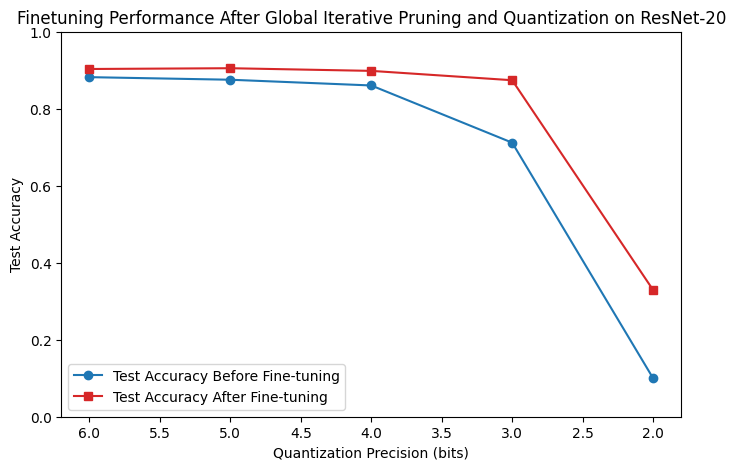

In [84]:
bits = [6, 5, 4, 3, 2]
accuracy_before = [0.8820, 0.8753, 0.8604, 0.7118, 0.1000]
accuracy_after = [0.9032, 0.9052, 0.8983, 0.8740, 0.3292]

y_acc_min, y_acc_max = 0.0, 1.0

plt.figure(figsize=(8, 5))
plt.plot(bits, accuracy_before, marker='o', linestyle='-', label='Test Accuracy Before Fine-tuning', color='tab:blue')
plt.plot(bits, accuracy_after, marker='s', linestyle='-', label='Test Accuracy After Fine-tuning', color='tab:red')

plt.xlabel('Quantization Precision (bits)')
plt.ylabel('Test Accuracy')
plt.title('Finetuning Performance After Global Iterative Pruning and Quantization on ResNet-20')
plt.ylim(y_acc_min, y_acc_max)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

### Lab4 (a) Symmetric quantization
#### Implement symmetric quantization in FP_layers.py, and repeat the process in (b)

In [ ]:
# check the performance of symmetric quantization with 6, 5, 4, 3, 2 bits

In [87]:
fp_path = '/content/drive/MyDrive/2023 - Duke/2025-01/ECE661_ComputerEngineeringMachineLearning&DeepNeuralNets/Assigments/HW4/V2FP_layers.py'
spec = importlib.util.spec_from_file_location("FP_layers", fp_path)
FP_layers = importlib.util.module_from_spec(spec)
sys.modules["FP_layers"] = FP_layers

from FP_layers import *

## Nbits = 6

In [88]:
Nbits = 6
symmetric = True

net = ResNetCIFAR(num_layers=20, Nbits=Nbits, symmetric=symmetric)
net = net.to(device)
net.load_state_dict(torch.load(pretrained_model_path))
test(net)

Test Loss=0.3231, Test accuracy=0.9151


## Nbits = 5

In [89]:
Nbits = 5
symmetric = True

net = ResNetCIFAR(num_layers=20, Nbits=Nbits, symmetric=symmetric)
net = net.to(device)
net.load_state_dict(torch.load(pretrained_model_path))
test(net)

Test Loss=0.3231, Test accuracy=0.9151


## Nbits = 4

In [90]:
Nbits = 4
symmetric = True

net = ResNetCIFAR(num_layers=20, Nbits=Nbits, symmetric=symmetric)
net = net.to(device)
net.load_state_dict(torch.load(pretrained_model_path))
test(net)

Test Loss=0.3231, Test accuracy=0.9151


## Nbits = 3

In [91]:
Nbits = 3
symmetric = True

net = ResNetCIFAR(num_layers=20, Nbits=Nbits, symmetric=symmetric)
net = net.to(device)
net.load_state_dict(torch.load(pretrained_model_path))
test(net)

Test Loss=0.3231, Test accuracy=0.9151


## Nbits = 2

In [92]:
Nbits = 2
symmetric = True

net = ResNetCIFAR(num_layers=20, Nbits=Nbits, symmetric=symmetric)
net = net.to(device)
net.load_state_dict(torch.load(pretrained_model_path))
test(net)

Test Loss=0.3231, Test accuracy=0.9151
